# DEA Coastlines validation

To do:
* [X] Change output CRS to Australian Albers
* [X] Discard validation sides with multiple intersects?
* [X] Split analysis code into:
    * Aggregate multiple profiles and export into single file
    * Analyse and plot single file
* [ ] Add extraction of environmental data for each profile line

## Load modules/functions


In [3]:
%matplotlib inline
%load_ext line_profiler
%load_ext autoreload
%autoreload 2

import sys
import glob
import numpy as np
import geopandas as gpd
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from shapely.geometry import box
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

sys.path.append('/g/data/r78/DEACoastlines/')
import deacoastlines_validation as deacl_val
import deacoastlines_statistics as deacl_stats

def to_vector(df,
              fname='test.shp',
              x='x',
              y='y',
              crs='EPSG:3577',
              output_crs='EPSG:3577'):
    
    # Convert datetimes to strings
    df = df.copy()
    is_datetime = df.dtypes == 'datetime64[ns]'
    df.loc[:, is_datetime] = df.loc[:, is_datetime].astype(str) 
    
    # Export to file
    gdf = gpd.GeoDataFrame(data=df.loc[:, df.dtypes != 'datetime64[ns]'],
                     geometry=gpd.points_from_xy(x=df[x], y=df[y]),
                     crs=crs).to_crs(output_crs).to_file(fname)
    
    return gdf


def export_eval(df, output_name, output_crs='EPSG:3577'):
    
    from shapely.geometry import box, Point, LineString

    # Extract geometries
    val_points = gpd.points_from_xy(x=df.val_x, y=df.val_y)
    deacl_points = gpd.points_from_xy(x=df.deacl_x, y=df.deacl_y)
    df_profiles = df.groupby('id').first()
    profile_lines = df_profiles.apply(
        lambda x: LineString([(x.start_x, x.start_y), (x.end_x, x.end_y)]), axis=1)

    # Export validation points
    val_gdf = gpd.GeoDataFrame(data=df,
                               geometry=val_points,
                               crs=output_crs).to_crs('EPSG:4326')
    val_gdf.to_file(f'figures/eval/{output_name}_val.geojson', 
                    driver='GeoJSON')

    # Export DEACL points
    deacl_gdf = gpd.GeoDataFrame(data=df,
                                 geometry=deacl_points,
                                 crs=output_crs).to_crs('EPSG:4326')
    deacl_gdf.to_file(f'figures/eval/{output_name}_deacl.geojson', 
                      driver='GeoJSON')

    # Export profiles
    profile_gdf = gpd.GeoDataFrame(data=df_profiles,
                                 geometry=profile_lines,
                                 crs=output_crs).to_crs('EPSG:4326')
    profile_gdf.to_file(f'figures/eval/{output_name}_profiles.geojson', 
                        driver='GeoJSON')
    

In [ ]:
# to_vector(output_stats, fname='test6.shp', x='0_x', y='0_y', crs='EPSG:3577')

## Pre-processing


### Moruya

In [34]:
deacl_val.preprocess_moruya(fname_out='output_data/moruya.csv', datum=0, overwrite=True)

### Victoria/Deakin
* [X] Renovated

In [184]:
deacl_val.preprocess_vicdeakin(fname='input_data/vicdeakin/z_data_10cm_VIC.csv',
                               datum=0)

### WRL Narrabeen 
* [X] Renovated

In [100]:
deacl_val.preprocess_narrabeen(fname='input_data/wrl/Narrabeen_Profiles_2018.csv',
                               datum=0,
                               overwrite=True)


### NSW Beach Profile Database
* [X] Renovated

In [24]:
for fname in glob.glob('input_data/nswbpd/*.csv'):
    profiles_df = deacl_val.preprocess_nswbpd(fname, 
                                              datum=0, 
                                              overwrite=True)     


/g/data/v10/public/modules/dea-env/20200713/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):



Dropping invalid profiles: 19                                                                              
Processing output_data/nswbpd_brunswick.csv                                                
Dropping invalid profiles: 1                                                                               
Processing output_data/nswbpd_saphirebeach.csv                                             
Dropping invalid profiles: 13                                                                              
Processing output_data/nswbpd_ballina.csv                                                  
Dropping invalid profiles: 1                                                                               
Processing output_data/nswbpd_boambeebeach.csv                                             
Dropping invalid profiles: 9                                                                               
Processing output_data/nswbpd_saltsbay.csv                                                 

### City of Gold Coast
* [X] Renovated
* [ ] Fix North Kirra name

In [41]:
sites = ['BILINGA', 'BROADBEACH', 'BURLEIGH HEADS', 'COOLANGATTA', 'CURRUMBIN',
         'DURANABH', 'FINGAL', 'GREENMOUNT HILL', 'KINGSCLIFF', 'KIRRA',
         'MAIN BEACH', 'MERMAID BEACH', 'MIAMI', 'Main Beach Cross Sections',
         'NARROWNECK', 'NO*TH KIRRA', 'PALM BEACH', 'POINT DANGER', 
         'RAINBOW BAY', 'SEAWAY CENTRE LINE', 'SNAPPER ROCKS', 
         'SOUTH STRADBROKE', 'SURFERS PARADISE', 'THE SPIT', 'TUGUN', 
         'TWEED RIVER ENTRANCE']
# sites=['SEAWAY CENTRE LINE']

for site in sites:
    profiles_df = deacl_val.preprocess_cgc(site=site,
                                           datum=0,
                                           overwrite=True)

Processing output_data/cgc_broadbeach.csv                                                  
Dropping invalid profiles: 2                                                                               
Processing output_data/cgc_palmbeach.csv                                                   
Dropping invalid profiles: 1                                                                               
Processing output_data/cgc_surfersparadise.csv                                             
Dropping invalid profiles: 3                                                                               


### TASMARC
* [X] Renovated

In [46]:
# List of sites to iterate over
sites = [i.split('/')[2] for i in glob.glob('input_data/tasmarc/*/')]
# sites = sites[2:]

for site in sites:
    deacl_val.preprocess_tasmarc(site, datum=0, overwrite=True) 


### WA DoT
* [X] Renovated

In [15]:
# Read in tertiary compartment file to regionalise results
tertiary_gdf = gpd.read_file('input_data/WA_tertiaryCC.shp').to_crs('EPSG:3577')
# tertiary_gdf = gpd.read_file('input_data/wa_sw.geojson').to_crs('EPSG:3577')
tertiary_gdf = tertiary_gdf.set_index('FROM_')

# Extract transects and validation distances
deacl_val.preprocess_wadot(regions_gdf=tertiary_gdf, 
                           fname='input_data/wadot/Coastline_Movements_20190819.gdb',
                           smartline='../input_data/Smartline.gdb',
                           aus_poly='/g/data/r78/rt1527/shapefiles/australia/australia/cstauscd_r.shp')

### WA DoT - Stirling

In [ ]:
deacl_val.preprocess_stirling(fname_out='output_data/stirling_stirling.csv',
                              datum=0)

In [47]:
import glob

output = []

for i in glob.glob('output_data/*.csv'):
        
    output.append(pd.read_csv(i))
    

In [48]:
test = pd.concat(output)

In [49]:
test.source.unique()

array(['aerial photogrammetry', 'hydrographic survey', 'lidar',
       'drone photogrammetry', 'total station/levelling', 'gps', 'emery',
       nan, 'terrestrial laser scanning', 'aerial photography'],
      dtype=object)

### SA Department of Environment and Water

In [ ]:
import math
from pyproj import Transformer

# Load data and set nodata values to NaN
wide_df = pd.read_csv('input_data/sadew/200011.CSV', na_values=[-9999])

# Reproject coords to Albers and create geodataframe
trans = Transformer.from_crs("EPSG:28354", "EPSG:28356", always_xy=True)
wide_df['EASTING'], wide_df['NORTHING'] = trans.transform(
    wide_df.EASTING.values, wide_df.NORTHING.values)

# Reshape into long format with each observation on a new row
profile_df = pd.melt(wide_df.drop('SAMPLE_NO', axis=1), 
                     id_vars=['EASTING', 'NORTHING', 'PROFILE'],
                     value_name='elevation').dropna()

# Set column names to lower case
profile_df.columns = profile_df.columns.str.lower()

# Extract date info
profile_df['date'] = profile_df['variable'].str[1:].str.strip()
profile_df['date'] = pd.to_datetime(profile_df['date'], format='%d%m%Y')

# Restrict to post 1987
profile_df = profile_df[(profile_df.date.dt.year > 1987)]

# Add unique ID column
profile_df['beach'] = 'sadew'
profile_df['section'] = 'all'
profile_df['profile'] = profile_df['profile'].astype(str)
profile_df['site'] = profile_df[['beach', 'section', 'profile']].apply('_'.join, 1)
profile_df['source'] = 'sadew'

# Compute origin points for each profile
profile_df = profile_df.assign(start_x=wide_df.iloc[0, 2], 
                               start_y=wide_df.iloc[0, 3],
                               end_x=wide_df.iloc[-1, 2],
                               end_y=wide_df.iloc[-1, 3])

# Compute chainage
profile_df['chainage'] = profile_df.apply(
    lambda x: math.hypot(x.easting - x.start_x, x.northing - x.start_y), axis=1)

In [ ]:
# Find location and distance to water for datum height (0 m AHD)
out = profile_df.groupby(['site', 'date']).apply(deacl_val.waterline_intercept, 
                                                  dist_col='chainage',
                                                  x_col='easting', 
                                                  y_col='northing', 
                                                  z_col='elevation', 
                                                  z_val=0).dropna()

# If the output contains data
if len(out.index):

    # Join into dataframe
    shoreline_dist = out.join(
        profile_df.groupby(['site', 'date']).first())

    # Keep required columns
    shoreline_dist = shoreline_dist[['beach', 'section', 'profile',  
                                     'source', 'start_x', 'start_y', 
                                     'end_x', 'end_y', '0_dist', 
                                     '0_x', '0_y']]

    # Export to file
    shoreline_dist.to_csv(f'output_data/satest.csv')

## Analysis
To investigate:
* [X] Outlier in Bermagui (Horseshoe Bay)
* [X] **Multiple outliers in Boambee Beach**
* [X] Single remaining outlier in Bogangar to Kingscliff
* [X] **Cluster of outliers in Burgess Beach: caused by one year of channel profiles**
* [X] Sporadic outliers in Byron Bay
* [X] Two remaining outlier in Corindi Beach
* [X] **Major outliers at Crowdy Head**
* [X] **String of outliers in opposite direction at Cullendulla**
* [X] One remaining outlier at Diamond Beach
* [X] One remaining outlier at Eurobadalla Beaches North
* [ ] **Cluster of outliers at Evans Head and Broadwater**
* [X] Two outliers in Fern Bay
* [ ] **Extreme outliers at Flynn's Beach**
* [ ] **Skewed result at Gerringong Harbour**
* [ ] Outliers in Hargrave's Beach
* [ ] Remaining outliers at Jimmy's Beach
* [X] **Remaining major outlier at Lake Illawarra**
* [X] **Outliers in Manly Beach**
* [X] **Outliers at Mooney Beach**
* [X] **Major issues with offset shorelines at Narrabeen/Collory**
* [X] Outlier at Ocean View Beach
* [X] **Outliers in opposite direction at Park's Beach**
* [X] Cluster of outliers at Patch's Beach
* [X] Outliers at Port Hacking 
* [X] **Weird line of points at Rainbow Beach**
* [X] **No relationship at Sandbar Beach**
* [ ] Outliers at Shellharbour Little Lake
* [X] One remaining outlier at Stuart's Point
* [ ] **Several remaining outliers at Swansea Belmont**
* [X] **Cluster of outliers at The Entrance**
* [X] Single outlier at Warrain
* [ ] **Major issues with Valla Beach**

In [178]:
val_paths = glob.glob('output_data/tasmarc_*.csv')
deacl_path = '/g/data/r78/DEACoastlines/DEACoastLines_coastlines_v1.0.0.shp'

stats_list = []

for val_path in val_paths:
    
    # Run analysis and close resulting figure
    print(f'{val_path:<80}', end='\r')
    output_stats = deacl_val.deacl_validation(val_path, 
                                              deacl_path,
                                              datum=0)
    
    # Append stats to list
    stats_list.append(output_stats)
    

In [181]:
stats_list

[                      id  year        beach section profile         source  \
 0  simpsonsbay_all_north  2013  simpsonsbay     all   north      Levelling   
 1  simpsonsbay_all_south  2013  simpsonsbay     all   south      Levelling   
 2  simpsonsbay_all_north  2014  simpsonsbay     all   north  Total station   
 3  simpsonsbay_all_south  2014  simpsonsbay     all   south      Levelling   
 4  simpsonsbay_all_north  2016  simpsonsbay     all   north      Levelling   
 5  simpsonsbay_all_south  2016  simpsonsbay     all   south  Total station   
 
   certainty  n       start_x       start_y         end_x         end_y  \
 0      good  1  1.285538e+06 -4.805556e+06  1.285431e+06 -4.805398e+06   
 1      good  1  1.282404e+06 -4.808312e+06  1.282363e+06 -4.808107e+06   
 2      good  2  1.285538e+06 -4.805556e+06  1.285431e+06 -4.805398e+06   
 3      good  2  1.282404e+06 -4.808312e+06  1.282363e+06 -4.808107e+06   
 4      good  1  1.285538e+06 -4.805556e+06  1.285431e+06 -4.805398e+0

In [179]:
# Combine stats into a dataframe
stats_df = pd.concat(stats_list)
stats_df.head()

ValueError: Plan shapes are not aligned

In [70]:
# # Export evaluation vector
output_name = 'moruya'
export_eval(stats_df, output_name)

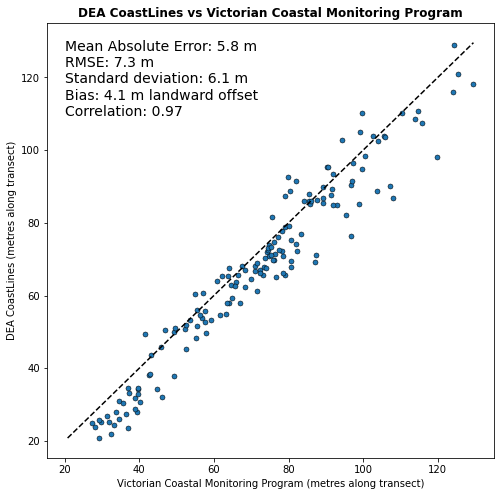

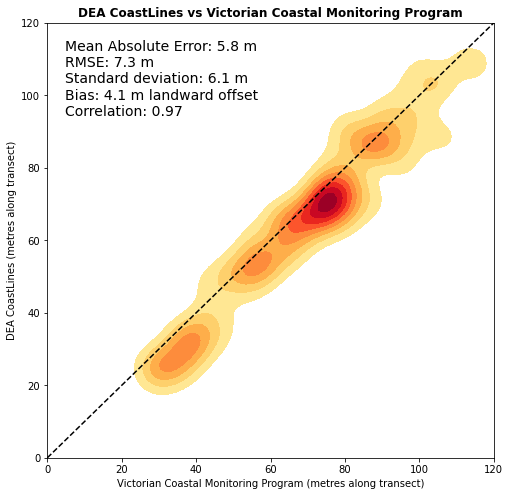

In [177]:
# Print stats and plot scatterplot
stats_subset = stats_df  #.loc[stats_df.id.isin(['bussleton_all_31'])]

def val_plot(df, 
             title='Validation',
             scatter=True, 
             density=True,
             time=True, 
             time_stat='mean',
             time_legend_pos=[0.8, 0.035],
             offset=0,
             extent=(0, 120),
             scatter_kwargs={}, 
             time_kwargs={}):
    
    # Copy data and apply offset
    df = df.copy()
    df['deacl_dist'] += offset

    # Compute stats
    mae = mean_absolute_error(df.val_dist, df.deacl_dist)
    rmse = mean_squared_error(df.val_dist, df.deacl_dist) ** 0.5
    stdev = df[["diff_dist"]].std().iloc[0]
    corr = df[["val_dist", "deacl_dist"]].corr().iloc[0, 1]
    bias = df[["diff_dist"]].mean().iloc[0]
    offset_str = 'landward offset' if bias > 0 else 'ocean-ward offset'

    if scatter:
        
        # Plot data as scatterplot
        fig, ax = plt.subplots(figsize=(8, 8))
        df.plot.scatter(x='val_dist',
                        y='deacl_dist',
                        s=25,
                        edgecolors='black',
                        linewidth=0.5,
#                         xlim=extent,
#                         ylim=extent,
                        ax=ax,
                        **scatter_kwargs)
        
        # Add dashed line
        
        
        ax.plot(
                np.linspace(df.loc[:, ['deacl_dist', 'val_dist']].values.min(), 
                            df.loc[:, ['deacl_dist', 'val_dist']].values.max()),
                np.linspace(df.loc[:, ['deacl_dist', 'val_dist']].values.min(), 
                            df.loc[:, ['deacl_dist', 'val_dist']].values.max()),
                color='black',
                linestyle='dashed')
        
        ax.set_xlabel(f'{title} (metres along transect)')
        ax.set_ylabel(f'DEA CoastLines (metres along transect)')
        
        # Add annotation
        ax.annotate(f'Mean Absolute Error: {mae:.1f} m\n' \
                    f'RMSE: {rmse:.1f} m\n' \
                    f'Standard deviation: {stdev:.1f} m\n' \
                    f'Bias: {bias:.1f} m {offset_str}\n' \
                    f'Correlation: {corr:.2f}\n',
                    xy=(0.04, 0.75),
                    fontsize=14,
                    xycoords='axes fraction')

        # Set title
        plt.gca().set_title(f'DEA CoastLines vs {title}', weight='bold')
        
        # Export to file        
        fig.savefig(f"{title}_scatter_offset{offset:.1f}.png", dpi=300)
        
    if density:
        
        fig, ax = plt.subplots(figsize=(8, 8))

        g = sns.kdeplot(ax=ax,
                        data=df.val_dist,
                        data2=df.deacl_dist, 
                        cmap='YlOrRd', 
                        shade=True,
                        bw=4,
                        shade_lowest=False,
                        clip=(extent, extent))

        g.set(xlabel=f'{title} (metres along transect)', 
              ylabel=f'DEA CoastLines (metres along transect)')
        ax.set_title(f'DEA CoastLines vs {title}', weight='bold')

        # Add stats annotation
        ax.annotate(f'Mean Absolute Error: {mae:.1f} m\n' \
                    f'RMSE: {rmse:.1f} m\n' \
                    f'Standard deviation: {stdev:.1f} m\n' \
                    f'Bias: {bias:.1f} m {offset_str}\n' \
                    f'Correlation: {corr:.2f}\n',
                    xy=(0.04, 0.75),
                    fontsize=14,
                    xycoords='axes fraction')

        # Add diagonal line
        plt.gca().plot(np.linspace(*extent), 
                       np.linspace(*extent),
                       color='black',
                       linestyle='dashed')
        
        plt.gca().set_ylim(bottom=extent[0])
        plt.gca().set_xlim(left=extent[0])

        # Export to file
        fig = g.get_figure()
        fig.savefig(f"{title}_heatmap_offset{offset:.1f}.png", dpi=300)
        
    if time:
        
        # Group by beach and apply statistic
        stats_grouped = (df.groupby(['beach', 'year'], as_index=False)
                         .aggregate(time_stat)
                         .rename({'beach': 'id',
                                  'deacl_dist': 'DEA CoastLines',
                                  'val_dist': title}, axis=1)
                         .groupby('id')
                         .filter(lambda x: len(x) > 1))

        # Melt data into long format for faceted plotting
        stats_melted = pd.melt(stats_grouped, 
                               id_vars=['id', 'year'],
                               value_vars=['DEA CoastLines', title],
                               value_name='Distance (m)')

        # Plot facet data
        g = sns.relplot(data=stats_melted,
                        x="year", 
                        y="Distance (m)", 
                        col="id", 
                        hue="variable",
                        height=1.7, 
                        aspect=1.0, 
                        kind="line", 
                        legend='full', 
                        col_wrap=5,
                        **time_kwargs)
        plt.subplots_adjust(top=0.9)
        g.fig.suptitle(f'DEA CoastLines vs {title}', 
                       weight='bold', 
                       ha='right')
        
        # Simplify titles
        g.set_titles(row_template='{row_name}', 
                     col_template='{col_name}')

        # Customise legend
        g._legend.texts[0].set_text("")
        g._legend.set_bbox_to_anchor(time_legend_pos)
        
        # Export to file
        g.savefig(f"{title}_time_offset{offset:.1f}.png", dpi=300)
        
    return pd.Series({'Mean Absolute Error': mae, 
                    f'RMSE': rmse,
                    f'Standard deviation': stdev,
                    f'Bias': f'{bias:.1f} m {offset_str}',
                    f'Correlation': corr})

        
# Run analysis
g = val_plot(df=stats_subset,
             title='Victorian Coastal Monitoring Program',
             scatter=True, 
             density=True,
             time=False,
             time_stat='median',
             time_legend_pos=[0.67, 0.11],
             offset=0,
             extent=(0, 120))

In [72]:
stats_subset['beach'] = stats_subset.id.str.split('_').str[0]

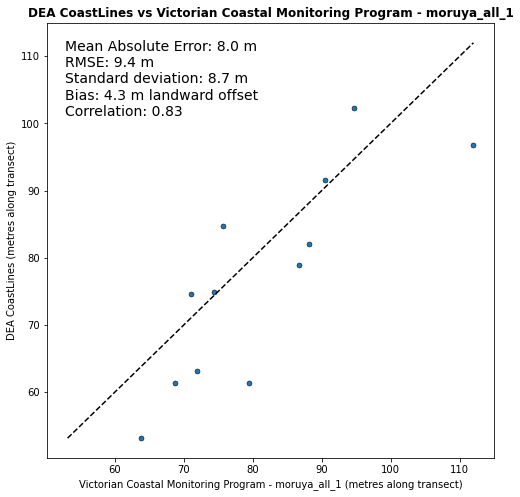

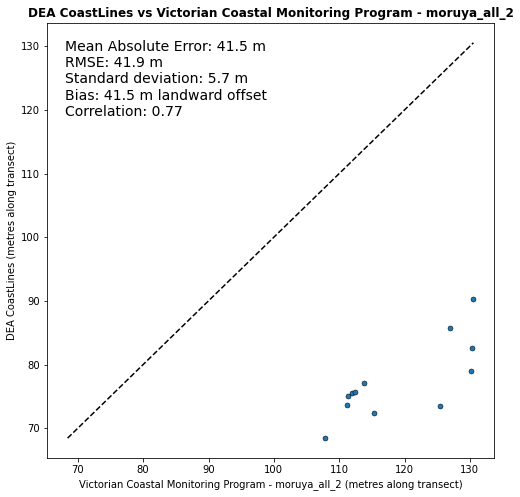

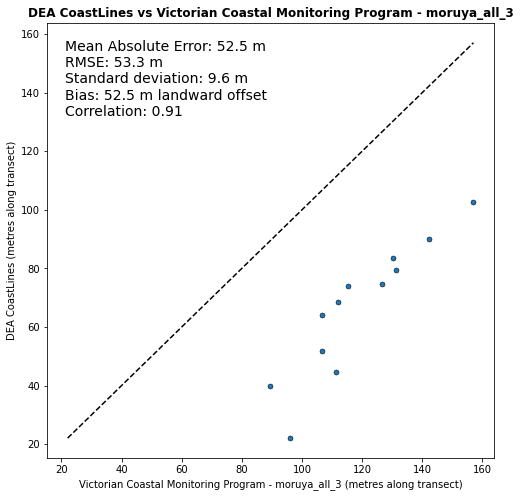

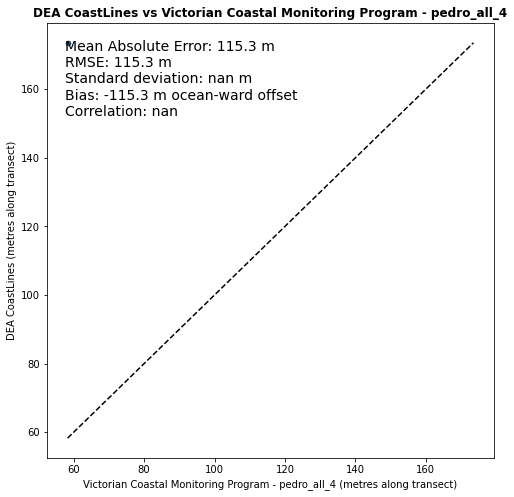

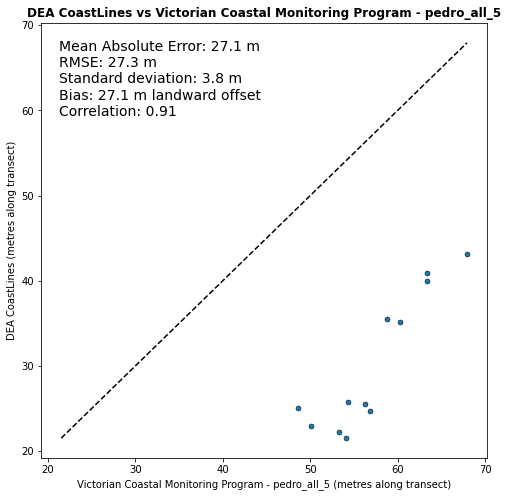

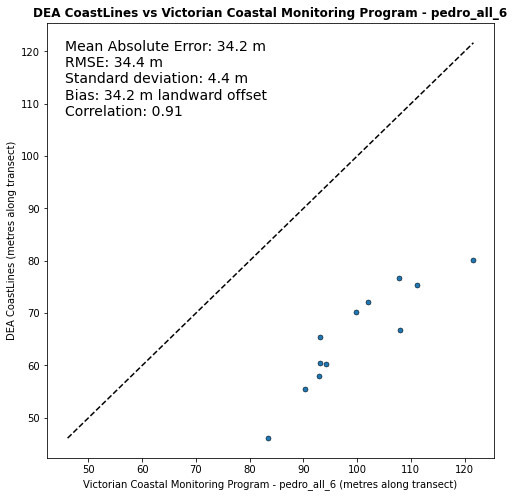

In [87]:
out_data = []

for beach in stats_subset.beach.unique():

    # Run analysis
    g = val_plot(df=stats_subset.loc[stats_subset.beach == beach],
                 title=f'Victorian Coastal Monitoring Program - {beach}',
                 scatter=True, 
                 density=False,
                 time=False,
                 time_stat='median',
                 time_legend_pos=[0.67, 0.11],
                 offset=0,
                 extent=(0, 120))
    
    out_data.append(g)

In [51]:
pd.DataFrame(out_data)

,Mean Absolute Error,RMSE,Standard deviation,Bias,Correlation
0,32.649641,36.366813,17.57215,31.9 m landward offset,0.755026


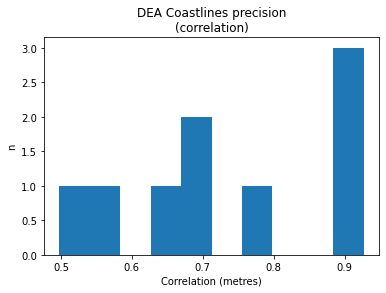

In [62]:
pd.DataFrame(out_data).loc[:, 'Correlation'].plot.hist()
plt.title('DEA Coastlines precision\n(correlation)')
plt.xlabel('Correlation (metres)')
plt.ylabel('n');


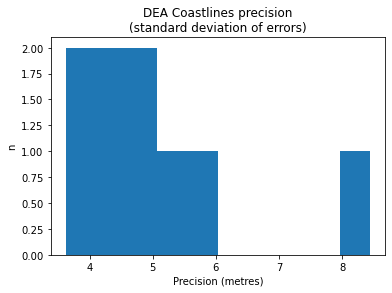

In [40]:
pd.DataFrame(out_data).loc[:, 'Standard deviation'].plot.hist()
plt.title('DEA Coastlines precision\n(standard deviation of errors)')
plt.xlabel('Precision (metres)')
plt.ylabel('n');


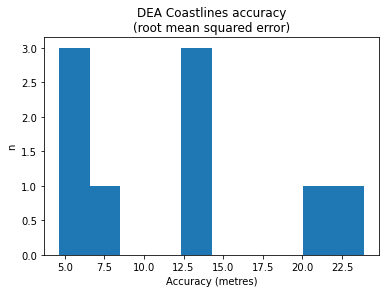

In [41]:
pd.DataFrame(out_data).loc[:, 'RMSE'].plot.hist()
plt.title('DEA Coastlines accuracy\n(root mean squared error)')
plt.xlabel('Accuracy (metres)')
plt.ylabel('n');

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** May 2020